In [0]:
# %%capture
# !pip install tensorflow==1.10.1
# !pip install numpy==1.14.5 

In [1]:
!git clone https://github.com/harshitjindal/covid19-timeseries-analysis

fatal: destination path 'covid19-timeseries-analysis' already exists and is not an empty directory.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
location = input("Enter location: ")

df = pd.read_csv("covid19-timeseries-analysis/dataset1.csv")
# df = df[['location','total_cases']]
#-----------
df = df[df['location']==location]['total_cases']
timeseries_y = list(df)
# print(timeseries_y[80:100])
#-----------

# lis1 = dict()
# for rows in df.itertuples():
#     if rows.location not in lis1:
#         lis1[rows.location] = []
#     lis1[rows.location].append(rows.total_cases)

# X = []
# y = []
# for key in lis1.keys():
#     lis = lis1[key]
#     n = len(lis)
#     for i in range(0,n-3):
#         temp = lis[i:i+3]
#         X.append(temp)
#         y.append(lis[i+3])

# X = np.array(X)
# X = X.reshape(len(X),1,3)
# print(len(y))

# timeseries_x, timeseries_y = X, y[5660:5775]
# timeseries_x
# timeseries_y

Enter location: India


y is [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 2.0000e+00 2.0000e+00 3.0000e+00
 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00
 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00
 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00
 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00
 3.0000e+00 3.0000e+00 3.0000e+00 5.0000e+00 6.0000e+00 2.8000e+01
 2.9000e+01 3.1000e+01 3.4000e+01 4.4000e+01 5.0000e+01 7.3000e+01
 7.5000e+01 8.3000e+01 9.0000e+01 9.3000e+01 1.2500e+02 1.3700e+02
 1.6500e+02 1.9100e+02 2.3100e+02 3.2000e+02 4.3900e+02 4.9200e+02
 5.6200e+02 6.4900e+02 7.2400e+02 8.7300e+02 9.7900e+02 1

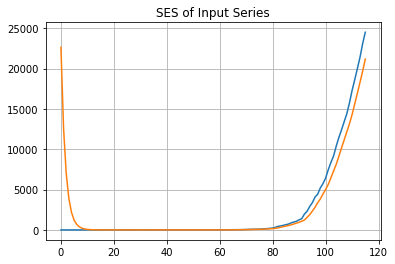

In [17]:
class SES(tf.keras.layers.Layer):
    def __init__(self, dtype=tf.float32):
        super(SES, self).__init__()
    
    def build(self, input_shape):
        self.alpha = self.add_weight('alpha', shape=[1,], 
                                     initializer=tf.keras.initializers.random_uniform(0,1), 
                                     constraint=tf.keras.constraints.min_max_norm(0,1))
        
        self.level = self.add_weight('level', shape=[1,], 
                                     initializer=tf.keras.initializers.truncated_normal())
        
    def call(self, input):
        
        def ses(y, alpha, level):
            '''Simple exponential smoothing using component form
            from Forecasting: Principles and Practice - Hyndman and George Athanasopoulos'''
            forecast = level
            updated_level = forecast + alpha * (y - forecast)
            return forecast, updated_level
        
        predictions = []
        for time_step in range(input.shape[0]):
            prediction, self.level = ses(input[time_step], self.alpha, self.level)
            predictions.append(prediction)
         
        return tf.concat(predictions, axis=-1)

# define mean squared loss function for simple exponential smoothing
def ses_loss(prediction, y):
    import sklearn.metrics

    loss = tf.losses.mean_squared_error(labels=y, predictions=prediction, weights=1)
    # loss = tf.keras.losses.MAPE(y, prediction)

    print('----- RMSE is:', sklearn.metrics.mean_squared_error(np.array(y), np.array(prediction)))
    return loss

if __name__ == "__main__":
    
    #define input series to be learned e.g. log with noise
    inpList = []
               
    # y = np.log(np.arange(1,3000,3))+np.random.normal(0,0.6,1000)
    # y = np.array([float(i) for i in inpList]) + np.random.normal(0,0.6,len(inpList))

    y = np.array([float(i) for i in timeseries_y])

    #define tensorflow dataset
    y_values = tf.data.Dataset.from_tensor_slices(y).batch(batch_size=y.shape[0])
    

    print('y is', y)
    # trash = input("\nStart training?")

    #training parameters
    training_epochs = 100
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate)

    loss_history = []
    
    #call SES layer
    ses_layer = SES()

    print('--------------------- SES training loss --------------------')
    for epoch in range(training_epochs):
        for yi in y_values:
            with tf.GradientTape() as tape:
                prediction = ses_layer(yi)
                loss = ses_loss(prediction, yi)

            loss_history.append(loss.numpy())
            grads = tape.gradient(loss, ses_layer.trainable_weights)
            optimizer.apply_gradients(zip(grads, ses_layer.trainable_weights), 
                                      global_step=None)
        
            if epoch % 50 == 0:
                print("Loss at step {:03d}: {:.3f}, alpha: {:.3f}, initial level: {:.3f}".format(epoch, loss, 
                      ses_layer.weights[0].numpy()[0],
                      ses_layer.weights[1].numpy()[0]))

    print("Final loss: {:.3f}".format(loss))
    print("alpha = {:.3f}, initial level = {:.3f}".format(ses_layer.weights[0].numpy()[0], 
          ses_layer.weights[1].numpy()[0]))
    
    plt.title('SES of Input Series')
    plt.plot(y)
    plt.plot(prediction.numpy())
    plt.grid(True)